<a href="https://colab.research.google.com/github/wgrgwrght/Hello_World_WSI/blob/main/Features_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloads

In [96]:
!git clone https://github.com/TissueImageAnalytics/tiatoolbox.git

Cloning into 'tiatoolbox'...
remote: Enumerating objects: 5823, done.
remote: Counting objects: 100% (159/159), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 5823 (delta 88), reused 133 (delta 73), pack-reused 5664
Receiving objects: 100% (5823/5823), 316.31 MiB | 20.58 MiB/s, done.
Resolving deltas: 100% (4188/4188), done.
Updating files: 100% (238/238), done.


In [97]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [98]:
cd tiatoolbox

/content/tiatoolbox/tiatoolbox/tiatoolbox


In [99]:
!conda create -n tiatoolbox-dev python=3.8 # select version of your choice
!conda activate tiatoolbox-dev
!pip install -r requirements_dev.txt

Solving environment: | / - \ done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 22.11.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /usr/local/envs/tiatoolbox-dev

  added / updated specs:
    - python=3.8


The following NEW packages will be INSTALLED:

  _libgcc_mutex      conda-forge/linux-64::_libgcc_mutex-0.1-conda_forge None
  _openmp_mutex      conda-forge/linux-64::_openmp_mutex-4.5-2_gnu None
  bzip2              conda-forge/linux-64::bzip2-1.0.8-h7f98852_4 None
  ca-certificates    conda-forge/linux-64::ca-certificates-2022.12.7-ha878542_0 None
  ld_impl_linux-64   conda-forge/linux-64::ld_impl_linux-64-2.40-h41732ed_0 None
  libffi             conda-forge/linux-64::libffi-3.4.2-h7f98852_5 None
  libgcc-ng          conda-forge/linux-64::libgcc-ng-12.2.0-h65d4601_19 None
  libgomp            conda-forge/linux-64::libgomp-12.2.0-h65d4601_

In [100]:
!conda activate tiatoolbox-dev


CommandNotFoundError: Your shell has not been properly configured to use 'conda activate'.
To initialize your shell, run

    $ conda init <SHELL_NAME>

Currently supported shells are:
  - bash
  - fish
  - tcsh
  - xonsh
  - zsh
  - powershell

See 'conda init --help' for more information and options.

IMPORTANT: You may need to close and restart your shell after running 'conda init'.




In [101]:
!apt-get -y install libopenjp2-7-dev libopenjp2-tools openslide-tools | tail -n 1
!pip install git+https://github.com/TissueImageAnalytics/tiatoolbox.git@develop | tail -n 1

print("Installation is done.")

0 upgraded, 0 newly installed, 0 to remove and 27 not upgraded.
  Running command git clone --filter=blob:none --quiet https://github.com/TissueImageAnalytics/tiatoolbox.git /tmp/pip-req-build-5bt6byby
Installation is done.


In [102]:
!pip install stardist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Imports

In [103]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [104]:
import sys
import os

print(sys.version)

py_file_location = "/content/drive"
sys.path.append(os.path.abspath(py_file_location))

3.8.10 (default, Nov 14 2022, 12:59:47) 
[GCC 9.4.0]


In [105]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams["figure.dpi"] = 150  # for high resolution figure in notebook
mpl.rcParams["figure.facecolor"] = "white"  # To make sure text is visible in dark mode
plt.rcParams.update({"font.size": 5})

In [106]:
from tiatoolbox.tools import patchextraction
from tiatoolbox.utils.misc import imread
from tiatoolbox.utils.misc import read_locations
from tiatoolbox.wsicore.wsireader import WSIReader
from tiatoolbox.models.engine.nucleus_instance_segmentor import NucleusInstanceSegmentor
from tiatoolbox.tools.patchextraction import PatchExtractor
from tiatoolbox.wsicore.wsireader import WSIReader
from tiatoolbox.tools.patchextraction import get_patch_extractor

import numpy as np
import cv2

from pprint import pprint

In [107]:
# Python standard library imports
from collections import OrderedDict
import glob
import copy
import pathlib
import random
import shutil
from typing import Callable, List, Tuple
import warnings
from pathlib import Path

# Third party imports
import joblib
import pandas as pd
from PIL import Image
from torchvision import transforms
from PIL.Image import new
import torch
from tqdm import tqdm

warnings.filterwarnings("ignore")

# ! save_yaml, save_as_json => need same name, need to factor out jsonify
from tiatoolbox.utils.misc import imread, save_as_json

mpl.rcParams["figure.dpi"] = 300  # for high resolution figure in notebook

In [108]:
SEED = 5
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [109]:
from skimage.exposure import equalize_hist
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from skimage import data
from skimage.color import rgb2hed, hed2rgb

In [110]:
from stardist.models import StarDist2D
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label
from csbdeep.utils import normalize

# Patch Extraction Function

In [111]:
def extract_patches(wsi):

  # Get Mask
  wsi_mask = wsi.tissue_mask(resolution=1, units="power")

  # * Generate patch coordinates (in xy format)
  wsi_shape = wsi.slide_dimensions(resolution=0.25, units="mpp")

  # Extrct Patches
  size_patch = 512

  fixed_patch = patchextraction.get_patch_extractor(
      input_img=wsi,  
      input_mask=wsi_mask,
      method_name="slidingwindow",  
      patch_size=(
          size_patch,
          size_patch,
      ),  
      stride=(size_patch, size_patch), 
      min_mask_ratio = 0.15
  )

  return fixed_patch

# Resnet50 Feature Extraction Function

In [112]:
def process_deep_feats(im, model):

  input_image = Image.fromarray(np.uint8(im))

  preprocess = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])

  input_tensor = preprocess(input_image)
  input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

  # move the input and model to GPU for speed if available
  if torch.cuda.is_available():
      input_batch = input_batch.to('cuda')
      model.to('cuda')

  with torch.no_grad():
      output = model(input_batch)

  return np.array(output[0].cpu())

In [113]:
def get_deep_feats(coords, wsi):

  # Define Model
  # model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
  model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)

  feats = []

  for box in tqdm(coords):
    img = wsi.read_bounds(box, resolution=0, units="level")
    feats.append(process_deep_feats(img, model))

  return feats

# Nucleus Feature Extraction Function

In [114]:
def process_stardist_feats(im, model):

  # Separate the stains from the IHC image
  ihc_hed = rgb2hed(im)

  # Create an RGB image for each of the stains
  null = np.zeros_like(ihc_hed[:, :, 0])
  ihc_h = hed2rgb(np.stack((ihc_hed[:, :, 0], null, null), axis=-1))

  # Predict
  axis_norm = (0,1)
  ihc_norm = normalize(ihc_h, 1, 99.8, axis=axis_norm)
  labels, details = model.predict_instances(ihc_norm, prob_thresh=0.3)

  ctrs = {}

  for cell_no in range(np.max(labels)):
      a = np.zeros_like(labels)
      a[labels==cell_no] = 150

      # Find Canny edges
      edged = cv2.Canny(np.uint8(a), 1, 10)

      # Finding Contours
      # Use a copy of the image e.g. edged.copy()
      # since findContours alters the image
      contours, hierarchy = cv2.findContours(edged, 
          cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

      ctrs[cell_no] = contours
  
  return ctrs

In [115]:
def get_stardist_feats(coords, wsi):
  # creates a pretrained model
  model = StarDist2D.from_pretrained('2D_versatile_he')

  contours = []

  for box in coords:
    img = wsi.read_bounds(box, resolution=0, units="level")
    contours.append(process_stardist_feats(img, model))

  return contours

In [116]:
# file_path = '/content/drive/MyDrive/Test images/NK22_184.mrxs'
# wsi = WSIReader.open(file_path)
# patches = extract_patches(wsi)

In [117]:
# get_stardist_feats(patches.coordinate_list, wsi)

In [118]:
# box = [79360,  5120, 79872,  5632]
# img = wsi.read_bounds(box, resolution=0, units="level")

# # creates a pretrained model
# model = StarDist2D.from_pretrained('2D_versatile_he')

# # Separate the stains from the IHC image
# ihc_hed = rgb2hed(img)

# # Create an RGB image for each of the stains
# null = np.zeros_like(ihc_hed[:, :, 0])
# ihc_h = hed2rgb(np.stack((ihc_hed[:, :, 0], null, null), axis=-1))
# plt.imshow(img)

# # Predict
# axis_norm = (0,1)
# img_gray_slice = normalize(ihc_h, 1, 99.8, axis=axis_norm)

# labels, details = model.predict_instances(img_gray_slice, prob_thresh=0.3)

# # print(len(details['points']))

# # print("edges")
# # # Find Canny edges
# # edged = cv2.Canny(np.uint8(labels),10,11)

# # print("contours")
# # # Finding Contours
# # # Use a copy of the image e.g. edged.copy()
# # # since findContours alters the image
# # contours, hierarchy = cv2.findContours(edged, 
# #     cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

In [119]:
# save_stardist_feats(patches, wsi)

In [120]:
# plt.imshow(labels)

In [121]:
# save_stardist_feats(patches, wsi)

In [122]:
# def example(model, i, show_dist=True):
#     img = normalize(X[i], 1,99.8, axis=axis_norm)
#     labels, details = model.predict_instances(img)

#     plt.figure(figsize=(13,10))
#     img_show = img if img.ndim==2 else img[...,0]
#     coord, points, prob = details['coord'], details['points'], details['prob']
#     plt.subplot(121); plt.imshow(img_show, cmap='gray'); plt.axis('off')
#     a = plt.axis()
#     _draw_polygons(coord, points, prob, show_dist=show_dist)
#     plt.axis(a)
#     plt.subplot(122); plt.imshow(img_show, cmap='gray'); plt.axis('off')
#     plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
#     plt.tight_layout()
#     plt.show()

In [123]:
# example(model_versatile, 30, False)

# Full function call

In [124]:
def process_wsi(wsi_paths, save_path):

  for i, wsi_path in enumerate(wsi_paths):
    print("Processing file ", i+1, " out of ", len(wsi_paths))
    file_name = Path(wsi_path).stem

    wsi = WSIReader.open(wsi_path)

    # Save Patch coords
    coord_path = f"{save_path}{file_name}.position.npz"
    patches = extract_patches(wsi) 
    if os.path.exists(coord_path):
      pass
    else:
      np.savez(coord_path, patches.coordinate_list)

    # Save Features
    feat_path = f"{save_path}{file_name}.features.npz"
    if os.path.exists(feat_path):
      pass
    else:
      features = get_deep_feats(patches.coordinate_list, wsi)
      # features = []
      np.savez(feat_path, features)
    
    # Save Contours
    cont_path = f"{save_path}{file_name}.contours.npz"
    if os.path.exists(cont_path):
      pass
    else:
      contours = get_stardist_feats(patches.coordinate_list, wsi)
      # contours = []
      np.savez(cont_path, contours)   

In [125]:
pth = "/content/drive/MyDrive/**/*.mrxs"
file_paths = glob.glob(pth, recursive=True)
save_path = '/content/drive/MyDrive/Test images/'

process_wsi(file_paths, save_path)

Processing file  1  out of  2


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
100%|██████████| 2535/2535 [15:50<00:00,  2.67it/s]


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.
1/1 [==============================] - 1s 664ms/step
Processing file  2  out of  2


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
100%|██████████| 3846/3846 [23:13<00:00,  2.76it/s]


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.
1/1 [==============================] - 1s 671ms/step


# Sanity Check

In [135]:
# load contours
coords = np.load("/content/drive/MyDrive/Test images/NK22_184.position.npz")['arr_0']
feats = np.load("/content/drive/MyDrive/Test images/NK22_184.features.npz")['arr_0']
conts = np.load("/content/drive/MyDrive/Test images/NK22_184.contours.npz", allow_pickle=True)

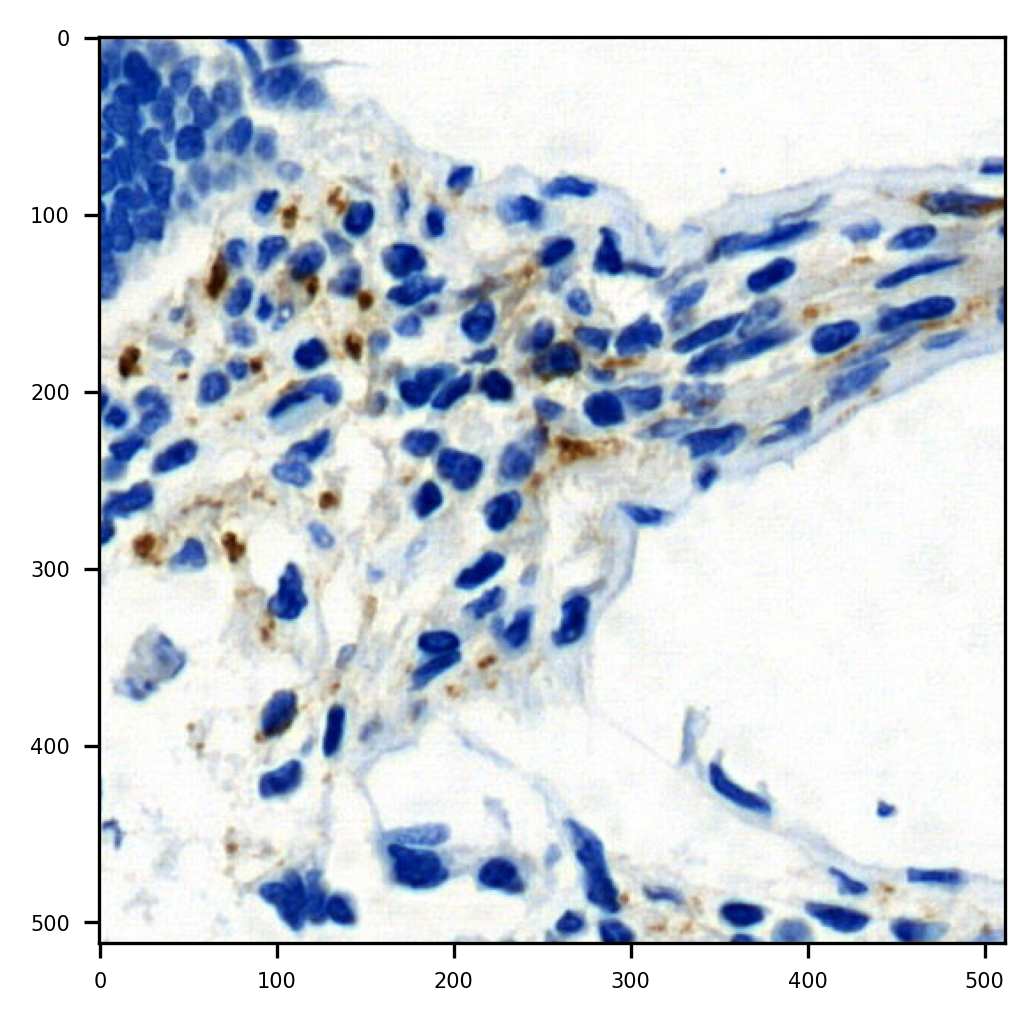

In [137]:
# Print patch
file_path = '/content/drive/MyDrive/Test images/NK22_184.mrxs'
wsi = WSIReader.open(file_path)
img = wsi.read_bounds(coords[1000], resolution=0, units="level")
plt.imshow(img)

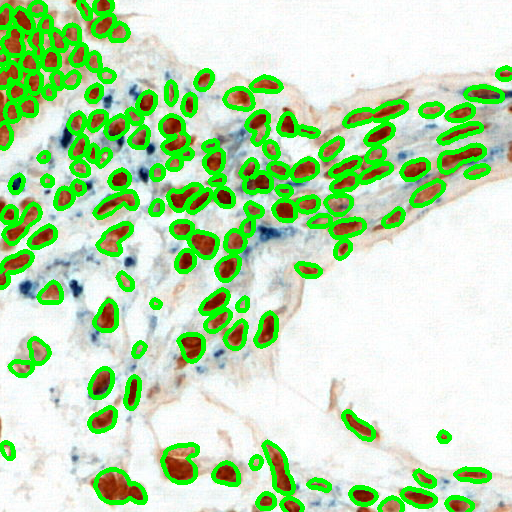

In [158]:
from google.colab.patches import cv2_imshow

# Print all contours 
cv2.drawContours(img, conts['arr_0'][1000][0], -1, (0,255,0), 3)
cv2_imshow(img)